In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-11-20 02:32:55.136288: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 02:32:55.240623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-20 02:32:55.240656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-20 02:32:55.254028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-20 02:32:55.285375: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Try advecting noise from Lagrangian to Eulerian space

### Generate a noise field with a random normal distribution

In [3]:
nbar_fid = 0.00022

def gen_noise_field(nbar_fid, n_grid=128, box_size=1000.0, seed=42):
    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

    rng = np.random.default_rng(seed=seed)

    noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
    noise_field /= n_grid**3
    return noise_field

In [4]:
noise_field_fid = gen_noise_field(nbar_fid)

### Load in muchisimocks displacements and construct particle positions

This is for LH0, a particular cosmology that doesn't necessarily match the mock we are trying to model. It's one I happen to have the displacements saved (hence the "rerun" in the path).

In [5]:
dir_mocks = '/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000_rerun'
subdir_prefix = 'LH'
idx_mock = 0
dir_LH = f'{dir_mocks}/{subdir_prefix}{idx_mock}'
fn_disp = f'{dir_LH}/pred_disp.npy'

In [6]:
pred_disp = np.load(fn_disp, allow_pickle=True)

In [7]:
n_grid = 128
box_size = 1000.0

In [8]:
## Create regular grid and displace particles
print("Generating grid", flush=True)
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements", flush=True)
pred_pos = bacco.scaler.add_displacement(None,
                                pred_disp,
                                box=box_size,
                                pos=grid.reshape(-1,3),
                                vel=None,
                                vel_factor=0,
                                verbose=True)[0]

Generating grid
Adding predicted displacements


2025-11-20 02:35:43,824 bacco.scaler : Adding displacement field with a vel-factor=0.000000


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


### Advect noise field to Eulerian space

In [9]:
noise_field_fid_eul = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pred_pos, 
                                mass = (noise_field_fid).flatten(), deposit_method='cic', 
                                interlacing=False)
noise_field_fid_eul = np.squeeze(noise_field_fid_eul)

2025-11-20 02:35:52,193 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
2025-11-20 02:35:54,066 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb


2025-11-20 02:35:54,736 bacco.statistics :  mesh done in 2.54 s


bacco.mesh : binning of 2097152 particles (2097152 with mass)


In [10]:
noise_field_fid_eul.shape

(128, 128, 128)

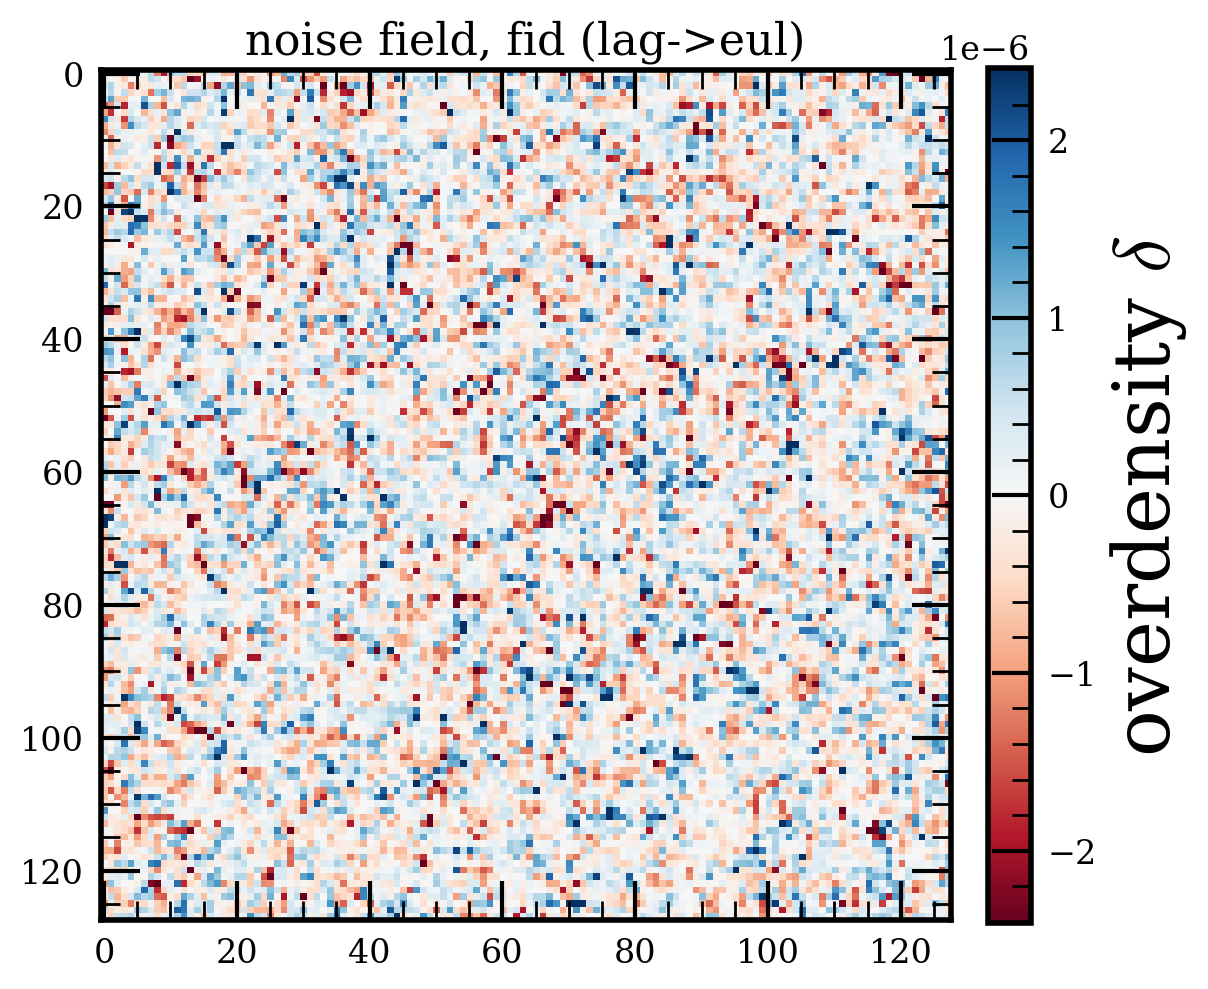

In [11]:
plotter.plot_overdensity_field(noise_field_fid_eul, title='noise field, fid (lag->eul)')

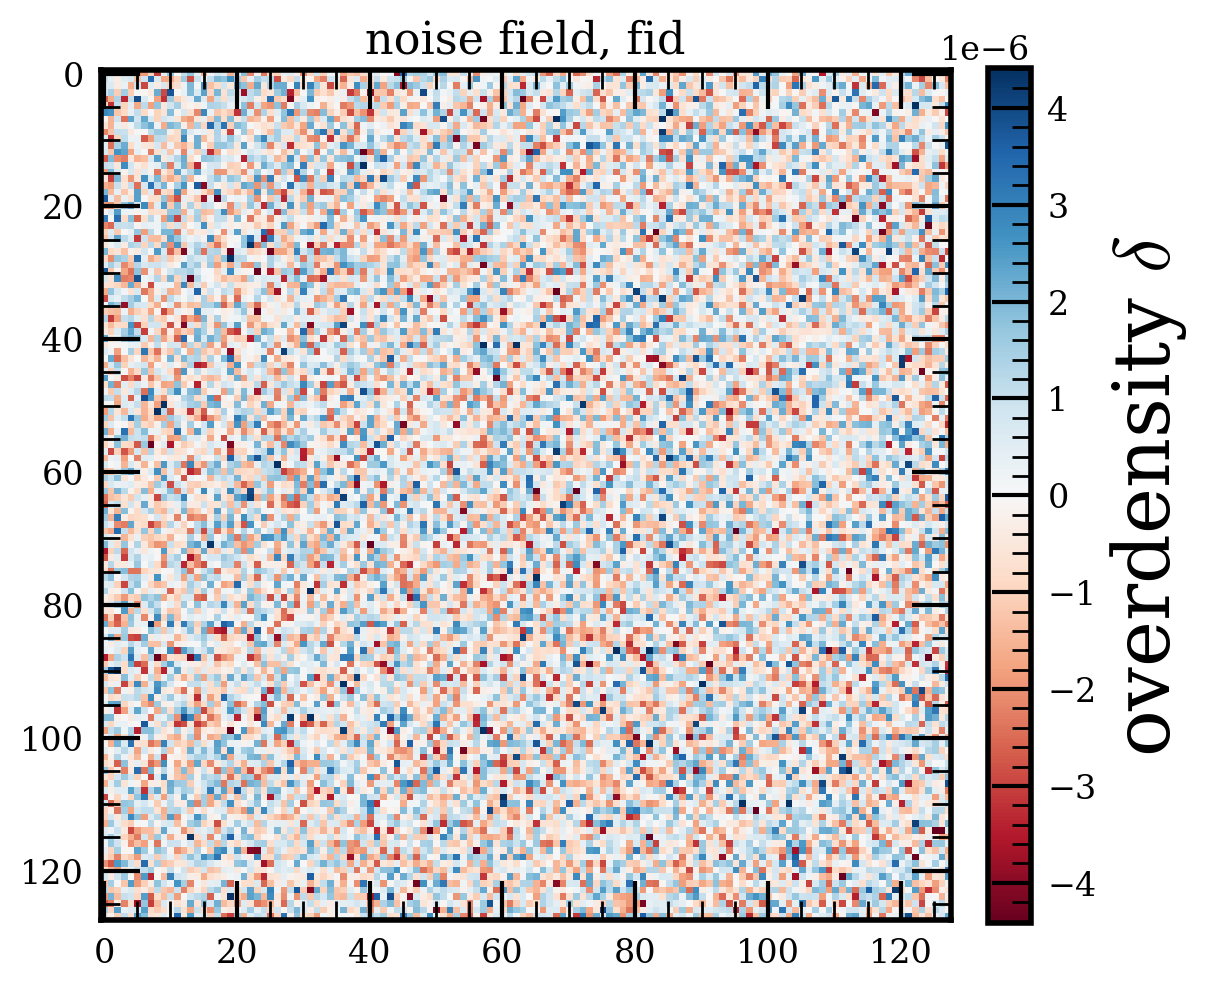

In [12]:
plotter.plot_overdensity_field(noise_field_fid, title='noise field, fid')

### Compute power spectra and bispectra

In [15]:
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)

In [16]:
pk_obj_noise = cs.compute_pk(noise_field_fid, cosmo, box_size,
                        n_threads=1)

Computing pk, using n_grid =  128


2025-11-20 02:36:32,969 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-20 02:36:34,536 bacco.statistics :  ...done in 1.57 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.015758 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042869 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000182 secs
bacco.power : Deallocating arrays


In [17]:
pk_obj_noiseeul = cs.compute_pk(noise_field_fid_eul, cosmo, box_size,
                        n_threads=1)

Computing pk, using n_grid =  128


2025-11-20 02:36:35,677 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-20 02:36:35,745 bacco.statistics :  ...done in 0.0679 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013986 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041777 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000163 secs
bacco.power : Deallocating arrays


In [18]:
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 2.27 s


In [19]:
bspec_noiseeul, bk_corr_noiseeul = cs.compute_bispectrum(base, noise_field_fid_eul)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [20]:
bspec_noise, bk_corr_noise = cs.compute_bispectrum(base, noise_field_fid)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


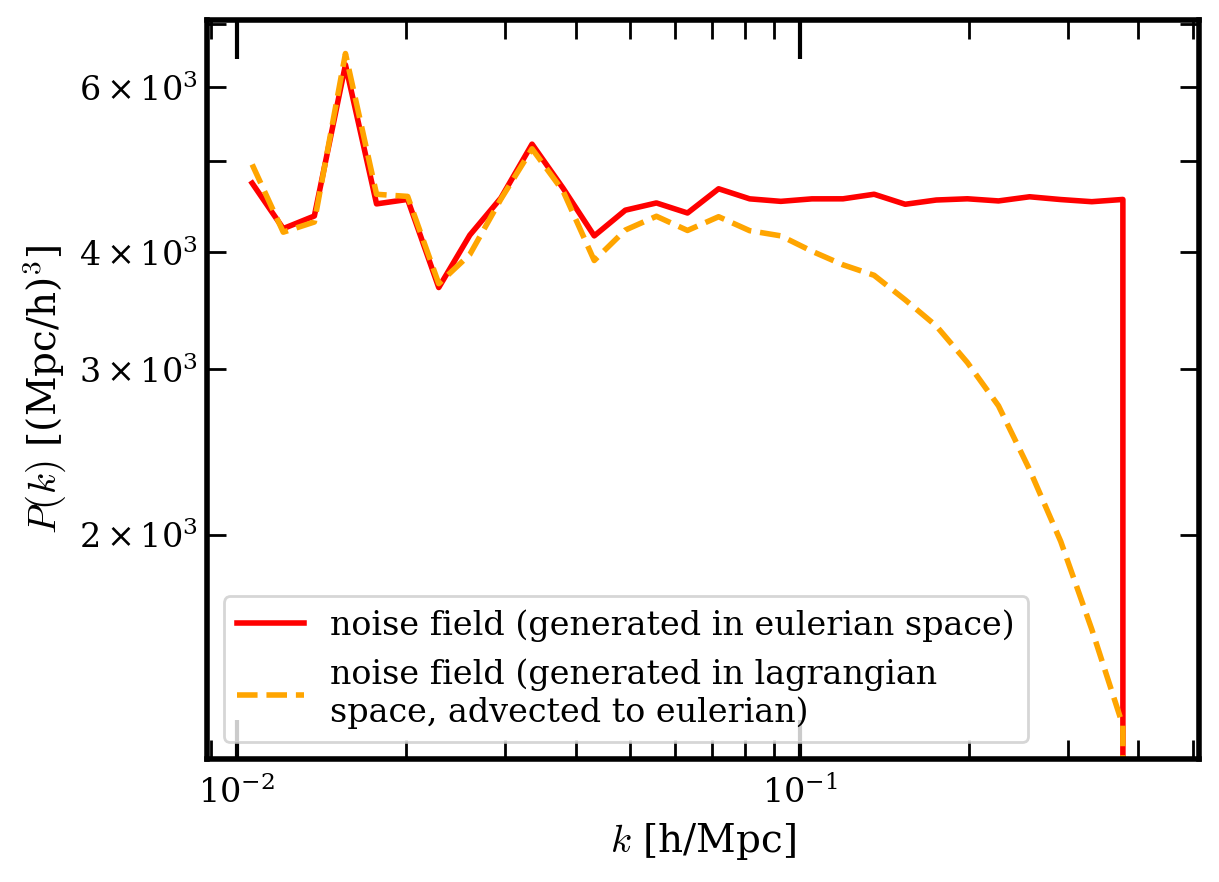

In [21]:
plt.plot(pk_obj_noise['k'], pk_obj_noise['pk'], color='red', ls='-', label='noise field (generated in eulerian space)', lw=2)
plt.plot(pk_obj_noiseeul['k'], pk_obj_noiseeul['pk'], color='orange', ls='--', label='noise field (generated in lagrangian\nspace, advected to eulerian)', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

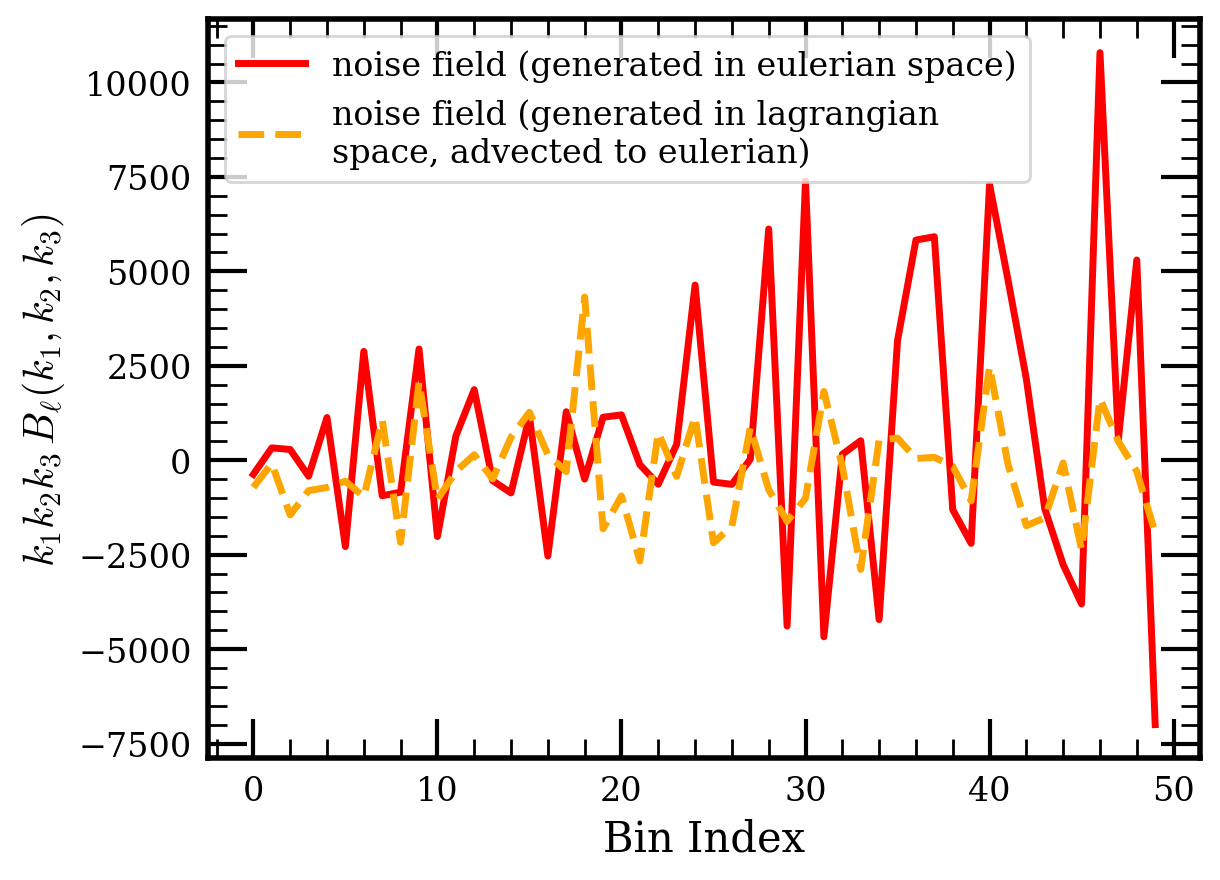

In [22]:
k123 = bspec_noiseeul.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3

plt.plot(norm**3 * weight*bk_corr_noise['b0'], color='red', ls='-', label='noise field (generated in eulerian space)')
plt.plot(norm**3 * weight*bk_corr_noiseeul['b0'], color='orange', ls='--', label='noise field (generated in lagrangian\nspace, advected to eulerian)')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)